In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage


from scipy import stats
import time
import warnings
warnings.filterwarnings('ignore')

Loading images from C:\Users\lsrin\Downloads\TS-2\Adavance_ML\Lab-5\TRAIL_DATA\TRAINING...
Processed 20 images from class glioma_tumor
Processed 19 images from class meningioma_tumor
Processed 25 images from class no_tumor
Processed 20 images from class pituitary_tumor

Dataset Summary:
Total images: 84
Number of classes: 4
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

Outlier Analysis:
Percentage of outliers: 1.61%

PCA Explained Variance Ratio: 58.52%

--- Hierarchical Clustering ---


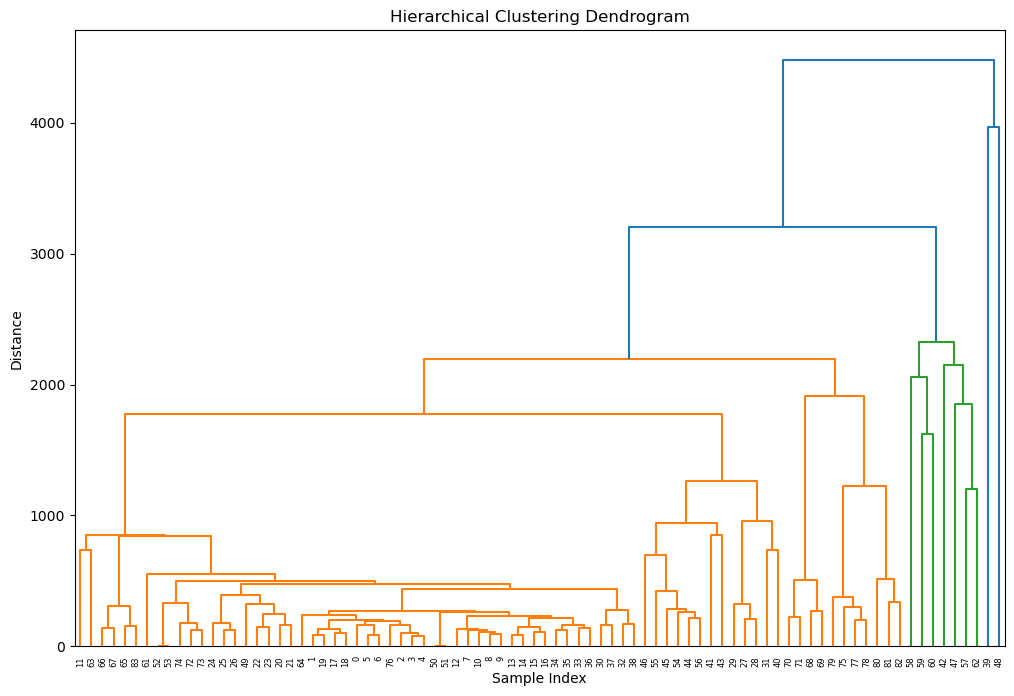


--- K-Means Clustering ---


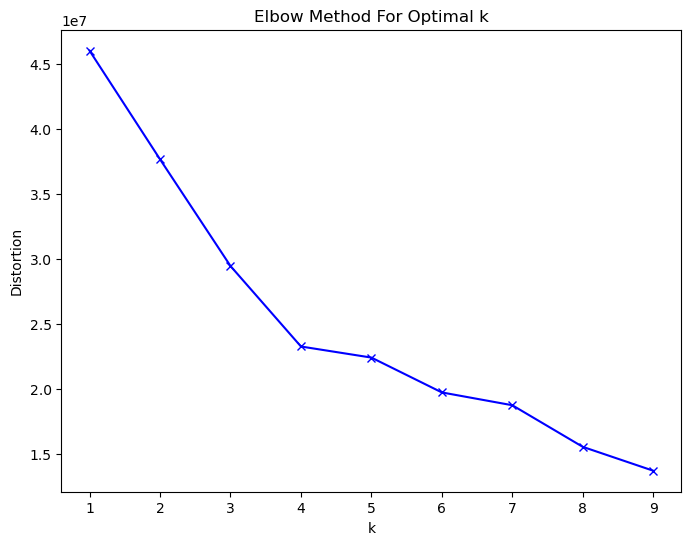


=== Clustering Evaluation ===

Hierarchical Clustering Results:
Execution Time: 2.05 seconds
Silhouette Score: 0.591
Davies-Bouldin Index: 1.108

K-Means Clustering Results:
Execution Time: 0.35 seconds
Silhouette Score: 0.594
Davies-Bouldin Index: 1.172


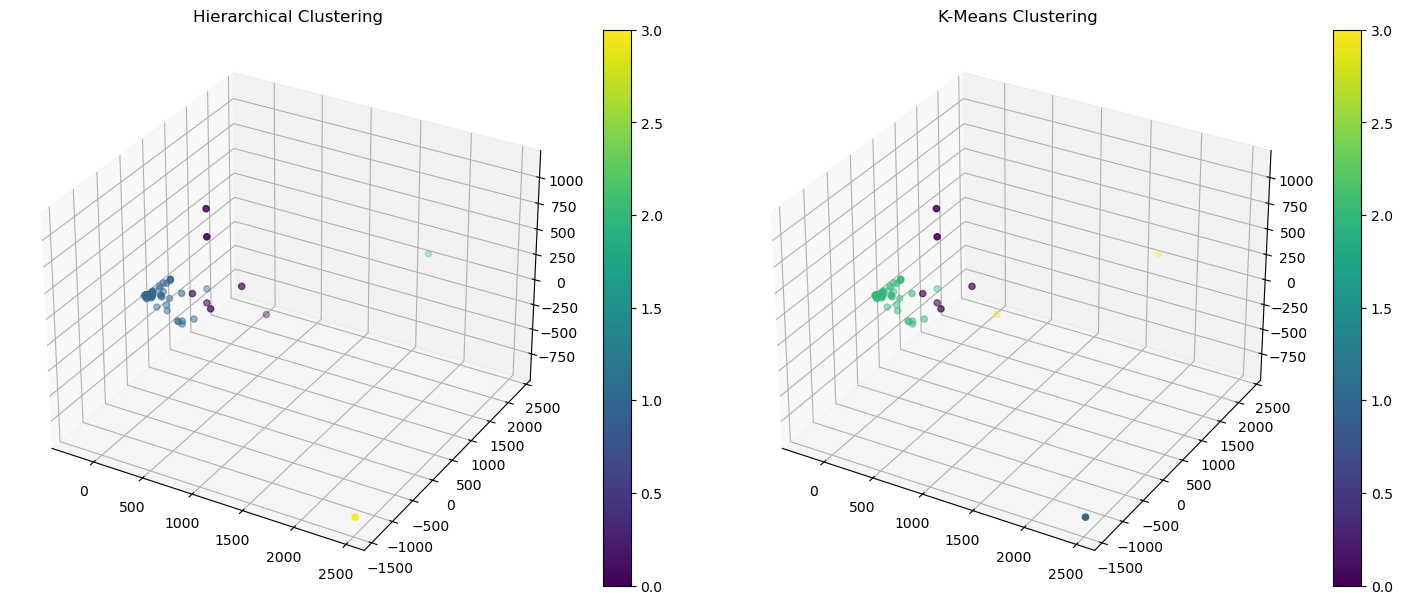


Recommendation: K-Means clustering appears more suitable for this dataset.


In [3]:
def load_and_preprocess_images(data_dir, target_size=(128, 128)):
    """Load and preprocess images from directory"""
    features = []
    labels = []
    classes = sorted(os.listdir(data_dir))
    
    print(f"Loading images from {data_dir}...")
    for label, cls in enumerate(classes):
        cls_folder = os.path.join(data_dir, cls)
        files_processed = 0
        for img_file in os.listdir(cls_folder):
            try:
                img_path = os.path.join(cls_folder, img_file)
                img = Image.open(img_path).resize(target_size).convert('RGB')
                img_array = np.array(img).flatten() / 255.0  # Normalize pixel values
                features.append(img_array)
                labels.append(label)
                files_processed += 1
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
        print(f"Processed {files_processed} images from class {cls}")
        
    return np.array(features), np.array(labels), classes

def prepare_data(features):
    """Prepare and preprocess the data"""
    # Check for outliers
    z_scores = stats.zscore(features)
    outliers = np.abs(z_scores) > 3
    outlier_percentage = (outliers.sum() / outliers.size) * 100
    print(f"\nOutlier Analysis:")
    print(f"Percentage of outliers: {outlier_percentage:.2f}%")
    
    # Standardize data
    scaler = RobustScaler()  # Using RobustScaler to handle outliers
    X_scaled = scaler.fit_transform(features)
    
    # Apply PCA
    pca = PCA(n_components=3)  # Keep 3 components for 3D visualization
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_
    print(f"\nPCA Explained Variance Ratio: {explained_variance.sum():.2%}")
    
    return X_scaled, X_pca

def visualize_clusters_3d(X_pca, y_hier, y_kmeans):
    """Create 3D visualization of clusters"""
    fig = plt.figure(figsize=(15, 6))
    
    # Hierarchical clustering plot
    ax1 = fig.add_subplot(121, projection='3d')
    scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_hier, cmap='viridis')
    ax1.set_title('Hierarchical Clustering')
    plt.colorbar(scatter1)
    
    # K-means clustering plot
    ax2 = fig.add_subplot(122, projection='3d')
    scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_kmeans, cmap='viridis')
    ax2.set_title('K-Means Clustering')
    plt.colorbar(scatter2)
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Set your paths
    train_dir = r"C:\Users\lsrin\Downloads\TS-2\Adavance_ML\Lab-5\TRAIL_DATA\TRAINING"  
    test_dir = r"C:\Users\lsrin\Downloads\TS-2\Adavance_ML\Lab-5\TRAIL_DATA\TESTING"    
    
    # Load and prepare data
    features, labels, classes = load_and_preprocess_images(train_dir)
    print(f"\nDataset Summary:")
    print(f"Total images: {len(features)}")
    print(f"Number of classes: {len(classes)}")
    print(f"Classes: {classes}")
    
    # Preprocess data
    X_scaled, X_pca = prepare_data(features)
    n_clusters = len(classes)
    
    # Hierarchical Clustering
    print("\n--- Hierarchical Clustering ---")
    start_time_hier = time.time()
    
    # Create and plot dendrogram
    linkage_matrix = linkage(X_scaled, method='ward')
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.show()
    
    # Perform hierarchical clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    y_hier = agg_clustering.fit_predict(X_scaled)
    hier_time = time.time() - start_time_hier
    
    # K-means Clustering
    print("\n--- K-Means Clustering ---")
    
    # Elbow method
    distortions = []
    K = range(1, min(10, len(features)))
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        distortions.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.figure(figsize=(8, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    
    # Perform K-means clustering
    start_time_kmeans = time.time()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    y_kmeans = kmeans.fit_predict(X_scaled)
    kmeans_time = time.time() - start_time_kmeans
    
    # Evaluate and compare results
    print("\n=== Clustering Evaluation ===")
    
    # Calculate metrics
    metrics = {
        'Hierarchical': {
            'Silhouette': silhouette_score(X_scaled, y_hier),
            'Davies-Bouldin': davies_bouldin_score(X_scaled, y_hier),
            #'Calinski-Harabasz': calinski_harabasz_score(X_scaled, y_hier),
            'Time': hier_time
        },
        'K-Means': {
            'Silhouette': silhouette_score(X_scaled, y_kmeans),
            'Davies-Bouldin': davies_bouldin_score(X_scaled, y_kmeans),
            #'Calinski-Harabasz': calinski_harabasz_score(X_scaled, y_kmeans),
            'Time': kmeans_time
        }
    }
    
    # Print results
    for method, scores in metrics.items():
        print(f"\n{method} Clustering Results:")
        print(f"Execution Time: {scores['Time']:.2f} seconds")
        print(f"Silhouette Score: {scores['Silhouette']:.3f}")
        print(f"Davies-Bouldin Index: {scores['Davies-Bouldin']:.3f}")
        #print(f"Calinski-Harabasz Score: {scores['Calinski-Harabasz']:.3f}")
    
    # Visualize clusters in 3D
    visualize_clusters_3d(X_pca, y_hier, y_kmeans)
    
    # Make recommendation
    if metrics['K-Means']['Silhouette'] > metrics['Hierarchical']['Silhouette']:
        print("\nRecommendation: K-Means clustering appears more suitable for this dataset.")
    else:
        print("\nRecommendation: Hierarchical clustering appears more suitable for this dataset.")

1.Run the script
2.The code will:
3.Load and preprocess your images
4.Perform both hierarchical and K-means clustering
5.Show visualizations (dendrogram, elbow curve, 3D cluster plots)
6.Provide detailed metrics and comparisons
7.Make a recommendation about which method is more suitable
8.The output will include:
Dataset summary
Outlier analysis
PCA explained variance
Clustering visualizations
Performance metrics for both methods
Final recommendation